In [111]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

pd.options.display.max_columns
pd.options.display.max_rows

60

## EDA

### Import datasets

In [112]:
orders = pd.read_csv('data/clean_data/online_retail_data.csv')
customers = pd.read_csv('data/clean_data/customers.csv')
products = pd.read_csv('data/clean_data/products.csv')

In [113]:
orders.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,line_total,cart_total_amount,cart_total_products,cart_total_units,first_date_of_purchase,last_date_of_purchase,recency,customer_tenure,NewDescription,ActiveMonth
354123,568652,21925,UNION STRIPE CUSHION COVER,12,2011-09-28 12:15:00,1.25,"15,841.00",United Kingdom,15.00,14.06,8.00,228.00,2011-01-05 11:25:00,2011-09-28 12:15:00,72 days 00:35:00,266 days 00:50:00,UNION STRIPE CUSHION COVER,Sep-2011
461307,576837,84580,MOUSE TOY WITH PINK T-SHIRT,2,2011-11-16 15:16:00,4.13,NaN,United Kingdom,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MOUSE TOY WITH PINK T-SHIRT,Nov-2011
7547,537051,21733,RED HANGING HEART T-LIGHT HOLDER,3,2010-12-05 11:12:00,2.95,"15,708.00",United Kingdom,8.85,162.58,31.00,158.00,2010-12-05 11:12:00,2011-10-30 10:54:00,40 days 01:56:00,328 days 23:42:00,RED HANGING HEART T-LIGHT HOLDER,Dec-2010
17281,537772,22738,RIBBON REEL SNOWY VILLAGE,5,2010-12-08 12:35:00,1.65,"18,043.00",United Kingdom,8.25,191.07,59.00,172.00,2010-12-08 12:35:00,2011-11-15 12:48:00,24 days 00:02:00,342 days 00:13:00,RIBBON REEL SNOWY VILLAGE,Dec-2010
163711,551057,23199,JUMBO BAG APPLES,2,2011-04-26 11:59:00,2.08,"16,942.00",United Kingdom,4.16,139.80,35.00,138.00,2011-04-26 11:59:00,2011-11-27 12:40:00,12 days 00:10:00,215 days 00:41:00,JUMBO BAG APPLES,Apr-2011


In [114]:
orders['recency'] = pd.to_timedelta(orders['recency']).dt.days
orders['customer_tenure'] = pd.to_timedelta(orders['customer_tenure']).dt.days

#### Total revenue

In [115]:
pd.options.display.float_format = '{:,.2f}'.format

In [116]:
orders['ActiveMonth'] = pd.to_datetime(orders['ActiveMonth'], format='%b-%Y')

In [117]:
print(f'Total Revenue: ${round(orders['line_total'].sum(), 2):,.2f}')

Total Revenue: $10,279,400.47


In [118]:
monthly_sales = orders.groupby('ActiveMonth').agg(Revenue=('line_total', 'sum')).reset_index()
monthly_sales['Month_Year'] = monthly_sales['ActiveMonth'].dt.strftime('%b-%Y')
monthly_sales = monthly_sales[['Month_Year', 'Revenue']]
monthly_sales['Growth_Rate'] = (monthly_sales['Revenue'].pct_change() * 100).fillna('--')
monthly_sales

,Month_Year,Revenue,Growth_Rate
0,Dec-2010,"778,625.91",--
1,Jan-2011,"672,207.41",-13.67
2,Feb-2011,"509,167.87",-24.25
3,Mar-2011,"692,015.94",35.91
4,Apr-2011,"516,754.79",-25.33
5,May-2011,"741,726.74",43.54
6,Jun-2011,"739,426.88",-0.31
7,Jul-2011,"689,947.74",-6.69
8,Aug-2011,"726,005.16",5.23
9,Sep-2011,"1,031,430.36",42.07


Key Observations:
- Seasonal Peaks: November 2011 ($1.46M) is your highest month, followed by October ($1.11M) and September ($1.03M) - Holiday season buildup

- Low Periods: February ($509K) and April ($517K) are the lowest

- December Anomaly: Dec 2011 ($616K) is much lower than Dec 2010 ($779K) - but it's only 12 days

- Growth Trend: Revenue increases through the year until November peak

####  Sales Volume Analysis (Market Demand + Market Trends)

**Monthly Transaction Count**

In [119]:
monthly_orders = orders.groupby('ActiveMonth').agg(
    Transaction_Count=('InvoiceNo', 'nunique'),
    Total_Units=('Quantity', 'sum'),
    Avg_Cart_Size_Units=('cart_total_units', 'mean')
).reset_index()
monthly_orders['Month_Year'] = monthly_orders['ActiveMonth'].dt.strftime('%b-%Y')
monthly_orders[['Month_Year', 'Transaction_Count', 'Total_Units', 'Avg_Cart_Size_Units']]

,Month_Year,Transaction_Count,Total_Units,Avg_Cart_Size_Units
0,Dec-2010,1552,358763,314.33
1,Jan-2011,1082,387432,446.32
2,Feb-2011,1093,283256,402.35
3,Mar-2011,1440,377125,409.46
4,Apr-2011,1237,308528,352.31
5,May-2011,1669,395405,401.50
6,Jun-2011,1525,388843,459.49
7,Jul-2011,1452,401369,394.74
8,Aug-2011,1340,421459,576.24
9,Sep-2011,1821,569970,478.93


**Transaction Count vs Revenue Correlation:**

* High Correlation: Revenue peaks align with transaction count peaks
    * Nov 2011: 2,753 transactions → $1.46M revenue 
    * Oct 2011: 2,008 transactions → $1.11M revenue 
    * Sep 2011: 1,821 transactions → $1.03M revenue

* Market Demand Impact: Clear holiday season surge in transactions

* Avg Cart Size: Generally increased from ~300 to ~500 units
* Peak: Aug 2011 (576 units/cart) despite moderate revenue
* Nov 2011: 408 units/cart - suggests higher-priced items, not bulk buying

**Average Order Value**

In [120]:
monthly_aov = orders.groupby('ActiveMonth').agg(
    AOV=('cart_total_amount', 'mean'),
    TotalRevenue=('line_total', 'sum'), 
    TotalOrders=('InvoiceNo', 'nunique')
).assign(
    Revenue_per_Transaction=lambda x: x['TotalRevenue'] / x['TotalOrders']
).reset_index()
monthly_aov['Month_Year'] = monthly_aov['ActiveMonth'].dt.strftime('%b-%Y')
monthly_aov[['Month_Year', 'AOV', 'Revenue_per_Transaction']]

,Month_Year,AOV,Revenue_per_Transaction
0,Dec-2010,110.15,501.69
1,Jan-2011,125.01,621.26
2,Feb-2011,122.58,465.84
3,Mar-2011,117.24,480.57
4,Apr-2011,103.62,417.75
5,May-2011,108.12,444.41
6,Jun-2011,114.93,484.87
7,Jul-2011,99.98,475.17
8,Aug-2011,133.53,541.79
9,Sep-2011,151.73,566.41


* AOV Increased Significantly: From $110 (Dec 2010) to $188 (Nov 2011) - 70% increase!

* Revenue-per-Transaction: More stable ($500-$600 range)

* Insight: Customers are buying more expensive items, not just more items (or the price got increased for some products)

In [144]:
monthly_customers = (
    orders[['ActiveMonth', 'CustomerID', 'InvoiceNo']]
    .drop_duplicates()  
)
customer_analysis = monthly_customers.groupby('ActiveMonth').agg(
    Unique_Customers=('CustomerID', 'nunique'),
    Repeat_Customers_Same_Month=('CustomerID', lambda x: x.value_counts().gt(1).sum()),
).reset_index()

customer_analysis['Retention_Rate'] = (
    customer_analysis['Repeat_Customers_Same_Month'] / customer_analysis['Unique_Customers'] * 100
)

recency_tenure = orders.groupby('ActiveMonth').agg(
    Avg_Recency=('recency', 'mean'),
    Avg_Tenure=('customer_tenure', 'mean')
)

customer_analysis = customer_analysis.merge(recency_tenure, on='ActiveMonth')
customer_analysis['Month_Year'] = customer_analysis['ActiveMonth'].dt.strftime('%b-%Y')

customer_analysis[
    ['Month_Year', 'Unique_Customers', 'Repeat_Customers_Same_Month',
     'Retention_Rate', 'Avg_Recency', 'Avg_Tenure']
]

,Month_Year,Unique_Customers,Repeat_Customers_Same_Month,Retention_Rate,Avg_Recency,Avg_Tenure
0,Dec-2010,885,263,29.72,80.67,285.01
1,Jan-2011,739,148,20.03,68.88,275.64
2,Feb-2011,757,147,19.42,68.71,261.67
3,Mar-2011,973,198,20.35,61.80,254.59
4,Apr-2011,853,164,19.23,59.92,248.93
5,May-2011,1055,275,26.07,48.00,257.12
6,Jun-2011,990,218,22.02,44.32,250.43
7,Jul-2011,946,224,23.68,39.82,248.40
8,Aug-2011,933,190,20.36,36.59,245.84
9,Sep-2011,1261,267,21.17,29.56,224.07


1. Customer Base Growth:

* Unique Customers: Grew from 885 - 1,661 (88% growth)
* Peak Acquisition: Nov 2011 added 300+ new customers vs Oct 2011

2. Retention Rate Trends:
* Volatile Retention: 29.7% (Dec 2010) - 20% (Q1) - 32.2% (Nov 2011 peak)
* Positive: Retention improved during revenue peaks
* Negative: Dec 2011 retention crashed to 17.1% (but only 12 days)

3. Recency & Tenure Insights:
* Avg Recency: From 81 days - 14 days (Nov 2011) - Customers are returning more frequently!
* Avg Tenure: From 285 - 216 days - suggests newer, more active customers



In [142]:
customer_months = orders[['ActiveMonth', 'CustomerID']].drop_duplicates()
customer_months = customer_months.sort_values('ActiveMonth')


month_list = customer_months['ActiveMonth'].unique()

returning_list = []

for i, month in enumerate(month_list):
    current_customers = set(customer_months[customer_months['ActiveMonth'] == month]['CustomerID'])
    
    # All customers who appeared before this month
    previous_customers = set(customer_months[customer_months['ActiveMonth'].isin(month_list[:i])]['CustomerID'])
    
    returning_count = len(current_customers & previous_customers)
    
    returning_list.append({
        "ActiveMonth": month,
        "Returning_Customers": returning_count
    })

returning_df = pd.DataFrame(returning_list)

customer_analysis2 = customer_analysis.merge(returning_df, on='ActiveMonth')
customer_analysis2['MoM_Returning_Rate'] = customer_analysis2['Returning_Customers'].pct_change() * 100 

In [143]:
customer_analysis2

,ActiveMonth,Unique_Customers,Repeat_Customers,Retention_Rate,Avg_Recency,Avg_Tenure,Month_Year,Returning_Customers,MoM_Returning_Rate
0,2010-12-01,885,263,29.72,80.67,285.01,Dec-2010,0,NaN
1,2011-01-01,739,148,20.03,68.88,275.64,Jan-2011,323,inf
2,2011-02-01,757,147,19.42,68.71,261.67,Feb-2011,377,16.72
3,2011-03-01,973,198,20.35,61.80,254.59,Mar-2011,521,38.20
4,2011-04-01,853,164,19.23,59.92,248.93,Apr-2011,553,6.14
5,2011-05-01,1055,275,26.07,48.00,257.12,May-2011,771,39.42
6,2011-06-01,990,218,22.02,44.32,250.43,Jun-2011,748,-2.98
7,2011-07-01,946,224,23.68,39.82,248.40,Jul-2011,759,1.47
8,2011-08-01,933,190,20.36,36.59,245.84,Aug-2011,764,0.66
9,2011-09-01,1261,267,21.17,29.56,224.07,Sep-2011,962,25.92


In [124]:
# Analyze price distribution changes
price_distribution = orders.groupby('ActiveMonth').agg(
    Avg_Price=('UnitPrice', 'mean'),
    Median_Price=('UnitPrice', 'median'),
    Price_Std=('UnitPrice', 'std'),
    Min_Price=('UnitPrice', 'min'),
    Max_Price=('UnitPrice', 'max')
).reset_index()

# Premium vs Discount mix
orders['Price_Category'] = pd.cut(orders['UnitPrice'], 
                                   bins=[0, 1, 5, 10, 50, 1000],
                                   labels=['<£1', '£1-5', '£5-10', '£10-50', '>£50'])

price_mix = orders.groupby(['ActiveMonth', 'Price_Category']).agg(
    Revenue_Share=('line_total', 'sum'),
    Transaction_Share=('InvoiceNo', 'nunique')
).reset_index()

C:\Users\takue\AppData\Local\Temp\ipykernel_19848\1012582019.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_mix = orders.groupby(['ActiveMonth', 'Price_Category']).agg(


In [125]:
price_distribution

,ActiveMonth,Avg_Price,Median_Price,Price_Std,Min_Price,Max_Price
0,2010-12-01,3.82,2.55,5.12,0.07,295.00
1,2011-01-01,3.34,2.10,4.72,0.10,295.00
2,2011-02-01,3.55,2.46,4.89,0.06,295.00
3,2011-03-01,3.47,2.10,5.47,0.08,295.00
4,2011-04-01,3.33,2.08,4.89,0.00,295.00
5,2011-05-01,3.46,2.10,4.77,0.08,295.00
6,2011-06-01,3.38,2.08,6.47,0.04,649.50
7,2011-07-01,3.04,1.95,3.74,0.00,125.00
8,2011-08-01,3.16,2.08,3.89,0.04,165.00
9,2011-09-01,3.09,2.08,3.89,0.00,165.00


In [147]:
price_mix[price_mix['Price_Category'].isin(['£10-50	', '>£50'])]

,ActiveMonth,Price_Category,Revenue_Share,Transaction_Share
4,2010-12-01,>£50,"5,046.79",21
9,2011-01-01,>£50,"4,140.35",23
14,2011-02-01,>£50,"2,424.96",10
19,2011-03-01,>£50,"4,472.98",24
24,2011-04-01,>£50,"2,428.25",11
29,2011-05-01,>£50,"2,893.38",16
34,2011-06-01,>£50,"41,832.53",17
39,2011-07-01,>£50,"1,497.10",17
44,2011-08-01,>£50,"1,791.36",16
49,2011-09-01,>£50,"2,931.67",19


In [127]:
# Price vs Quantity correlation
price_elasticity = orders.groupby('ActiveMonth').apply(
    lambda x: x['UnitPrice'].corr(x['Quantity'])
).reset_index()
price_elasticity.columns = ['ActiveMonth', 'Price_Quantity_Correlation']

# Price vs Revenue correlation
price_revenue_corr = orders.groupby('ActiveMonth').apply(
    lambda x: x['UnitPrice'].corr(x['line_total'])
).reset_index()
price_revenue_corr.columns = ['ActiveMonth', 'Price_Revenue_Correlation']

C:\Users\takue\AppData\Local\Temp\ipykernel_19848\2559607146.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  price_elasticity = orders.groupby('ActiveMonth').apply(
C:\Users\takue\AppData\Local\Temp\ipykernel_19848\2559607146.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  price_revenue_corr = orders.groupby('ActiveMonth').apply(


In [128]:
price_elasticity

,ActiveMonth,Price_Quantity_Correlation
0,2010-12-01,-0.08
1,2011-01-01,-0.01
2,2011-02-01,-0.08
3,2011-03-01,-0.09
4,2011-04-01,-0.08
5,2011-05-01,-0.09
6,2011-06-01,-0.07
7,2011-07-01,-0.10
8,2011-08-01,-0.11
9,2011-09-01,-0.10


In [129]:
price_revenue_corr

,ActiveMonth,Price_Revenue_Correlation
0,2010-12-01,0.12
1,2011-01-01,0.01
2,2011-02-01,0.09
3,2011-03-01,0.13
4,2011-04-01,0.08
5,2011-05-01,0.10
6,2011-06-01,0.53
7,2011-07-01,0.11
8,2011-08-01,0.07
9,2011-09-01,0.07


In [130]:
# 1. Price changes on same products
product_price_trend = orders.groupby(['StockCode', 'ActiveMonth']).agg(
    Avg_Price=('UnitPrice', 'mean'),
    Total_Sold=('Quantity', 'sum'),
    Revenue=('line_total', 'sum')
).reset_index()

# Find products with significant price changes
price_changes = product_price_trend.pivot_table(
    index='StockCode', 
    columns='ActiveMonth', 
    values='Avg_Price'
)
price_volatility = price_changes.std(axis=1).sort_values(ascending=False)

In [131]:
product_price_trend

,StockCode,ActiveMonth,Avg_Price,Total_Sold,Revenue
0,10002,2010-12-01,1.20,251,234.41
1,10002,2011-01-01,0.96,340,291.37
2,10002,2011-02-01,1.07,52,45.76
3,10002,2011-03-01,1.14,28,27.70
4,10002,2011-04-01,0.85,189,160.65
...,...,...,...,...,...
33485,PADS,2011-04-01,0.00,1,0.00
33486,PADS,2011-07-01,0.00,1,0.00
33487,PADS,2011-09-01,0.00,1,0.00
33488,S,2011-04-01,30.00,1,30.00


In [132]:
# 1. Unit Price Trend Analysis
unit_price_trend = orders.groupby('ActiveMonth').agg(
    Avg_Unit_Price=('UnitPrice', 'mean'),
    Median_Unit_Price=('UnitPrice', 'median'),
    Pct_Over_ten=('UnitPrice', lambda x: (x > 10).mean() * 100),
    Pct_Over_fifty=('UnitPrice', lambda x: (x > 50).mean() * 100)
).reset_index()

# 2. Price Change Impact Analysis
# Compare same products across months
top_products = orders['StockCode'].value_counts().head(20).index
top_products_data = orders[orders['StockCode'].isin(top_products)]

price_evolution = top_products_data.pivot_table(
    index='StockCode',
    columns='ActiveMonth',
    values='UnitPrice',
    aggfunc='mean'
)

# 3. Price Basket Analysis
orders['Price_Per_Item'] = orders['line_total'] / orders['Quantity']
price_basket = orders.groupby('ActiveMonth').agg(
    Avg_Price_Per_Item=('Price_Per_Item', 'mean'),
    High_Price_Items=('UnitPrice', lambda x: (x > 20).sum()),
    Low_Price_Items=('UnitPrice', lambda x: (x < 5).sum())
).reset_index()

In [133]:
unit_price_trend

,ActiveMonth,Avg_Unit_Price,Median_Unit_Price,Pct_Over_ten,Pct_Over_fifty
0,2010-12-01,3.82,2.55,5.67,0.06
1,2011-01-01,3.34,2.10,3.93,0.07
2,2011-02-01,3.55,2.46,4.60,0.05
3,2011-03-01,3.47,2.10,4.59,0.08
4,2011-04-01,3.33,2.08,4.45,0.04
5,2011-05-01,3.46,2.10,4.62,0.06
6,2011-06-01,3.38,2.08,4.40,0.05
7,2011-07-01,3.04,1.95,3.71,0.04
8,2011-08-01,3.16,2.08,3.92,0.05
9,2011-09-01,3.09,2.08,3.37,0.04


In [134]:
price_evolution.fillna('')

ActiveMonth,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
StockCode,,,,,,,,,,,,,
20725,2.66,2.26,2.55,2.20,2.01,1.96,1.95,1.88,2.06,2.02,2.13,2.18,2.26
20727,2.38,2.43,2.27,2.09,2.18,1.96,1.99,1.97,2.13,2.05,1.98,2.09,2.31
20728,2.38,2.30,2.02,2.00,2.04,2.00,1.90,1.94,1.96,2.08,2.04,2.15,2.68
21212,0.77,0.76,0.74,0.70,0.71,0.72,0.75,0.74,0.80,0.76,0.74,0.79,1.19
21931,2.70,2.85,2.71,2.66,2.76,2.88,3.11,2.94,2.46,2.62,2.70,2.44,2.74
22086,3.38,5.97,5.12,3.53,3.90,5.12,4.53,3.73,3.56,3.37,3.35,3.23,3.21
22197,1.10,1.15,1.16,1.06,0.96,1.04,1.02,1.04,0.97,1.05,1.05,0.99,1.02
22382,2.11,2.16,1.79,1.80,2.04,2.06,1.98,2.02,2.02,2.00,2.16,1.93,2.06
22383,2.57,2.42,2.53,2.34,2.16,2.00,1.99,1.98,2.05,2.16,2.08,2.04,2.68


In [135]:
price_basket

,ActiveMonth,Avg_Price_Per_Item,High_Price_Items,Low_Price_Items
0,2010-12-01,3.82,410,32450
1,2011-01-01,3.34,198,28437
2,2011-02-01,3.55,150,21946
3,2011-03-01,3.47,229,29414
4,2011-04-01,3.33,172,24106
5,2011-05-01,3.46,196,29571
6,2011-06-01,3.38,233,29925
7,2011-07-01,3.04,192,33232
8,2011-08-01,3.16,160,29290
9,2011-09-01,3.09,175,42357


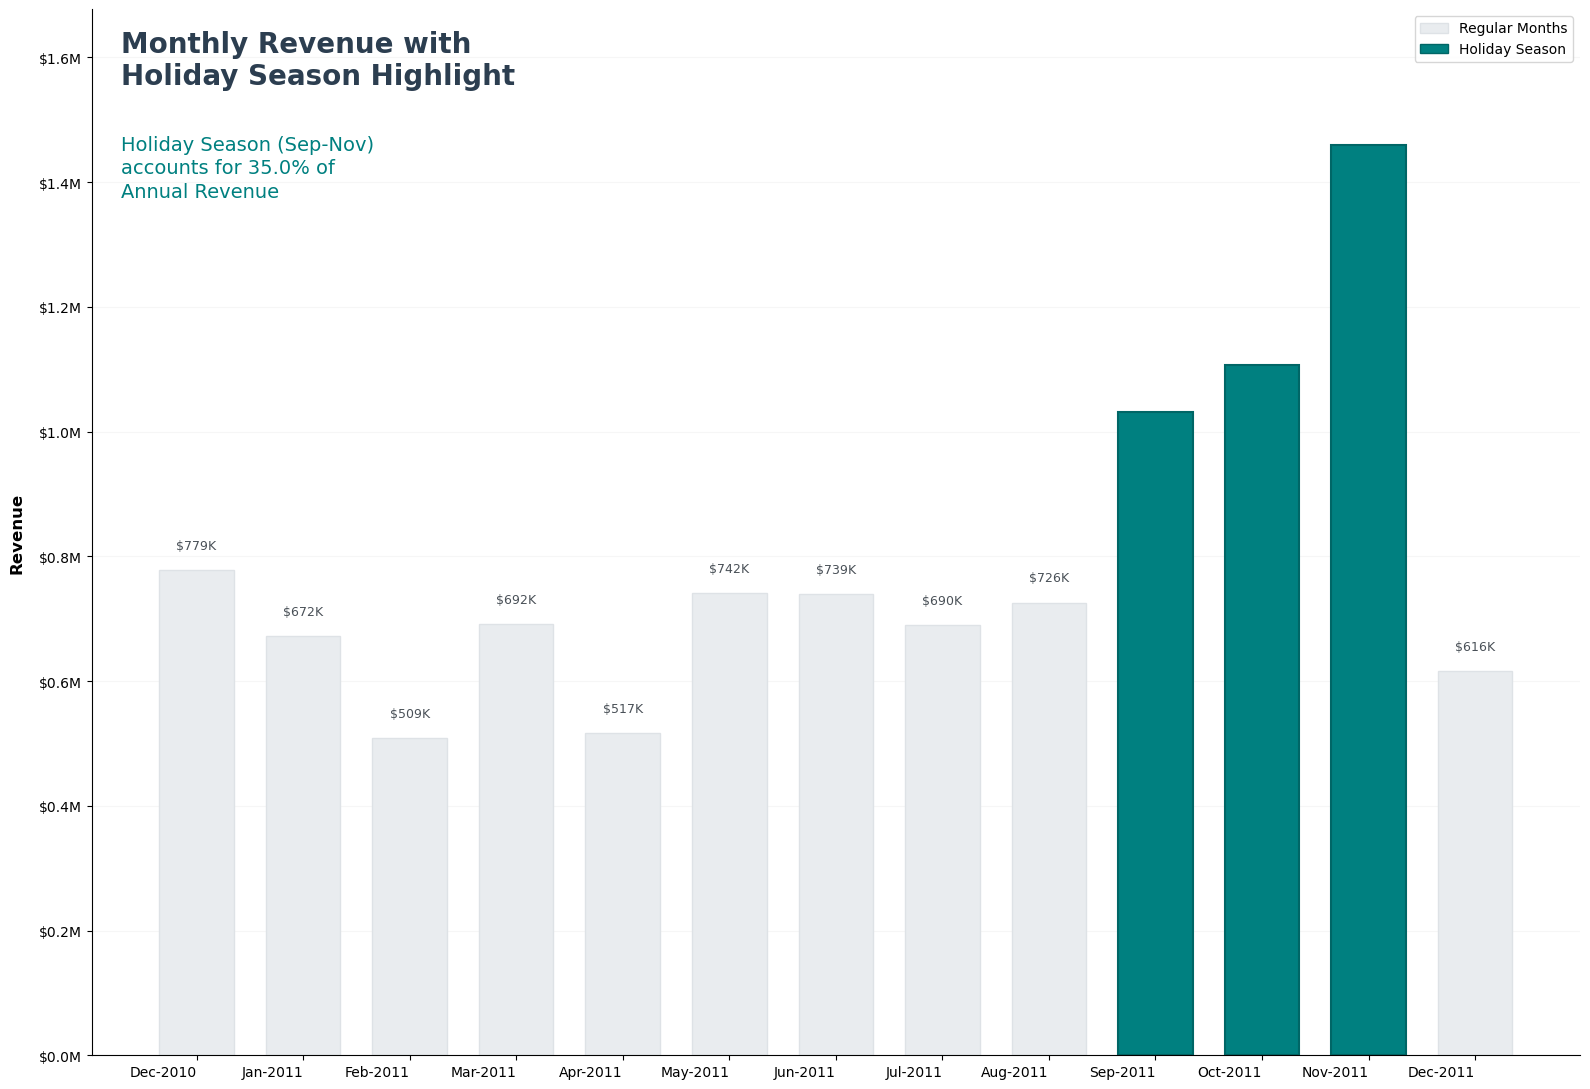

In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

# Calculate holiday percentage
months = monthly_sales['Month_Year'].to_list()
revenue = monthly_sales['Revenue'].to_list()
holiday_indices = [9, 10, 11]

total_revenue = sum(revenue)
holiday_revenue = sum([revenue[i] for i in holiday_indices])
holiday_percentage = (holiday_revenue / total_revenue) * 100

# Create figure
fig, ax = plt.subplots(figsize=(16,11))

# Set background
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor('#ffffff')

# Create bars
bars = ax.bar(months, revenue, color='#e9ecef', edgecolor='#dee2e6', linewidth=1, width=0.7)

# Highlight holiday season
for idx in holiday_indices:
    bars[idx].set_color('#008080')
    bars[idx].set_edgecolor('#006666')
    bars[idx].set_linewidth(1.5)

# ADD LEFT-ALIGNED TITLES WITHIN THE PLOT
# Main title
ax.text(0.02, 0.98, 'Monthly Revenue with\nHoliday Season Highlight', 
        transform=ax.transAxes, fontsize=20, fontweight='bold', 
        color='#2c3e50', va='top', ha='left', linespacing=1.2)

# Subtitle
ax.text(0.02, 0.88, f'Holiday Season (Sep-Nov)\naccounts for {holiday_percentage:.1f}% of\nAnnual Revenue', 
        transform=ax.transAxes, fontsize=14, fontweight='normal', 
        color='#008080', va='top', ha='left', linespacing=1.3)

# Format y-axis
def millions(x, pos):
    return f'${x/1000000:.1f}M'

ax.yaxis.set_major_formatter(FuncFormatter(millions))
ax.set_ylabel('Revenue', fontsize=12, fontweight='bold', labelpad=10)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, revenue)):
    height = bar.get_height()
    text_color = 'white' if i in holiday_indices else '#495057'
    font_weight = 'bold' if i in holiday_indices else 'normal'
    
    if value < 1000000:
        value_text = f'${value/1000:.0f}K'
    else:
        value_text = f'${value/1000000:.1f}M'
    
    ax.text(bar.get_x() + bar.get_width()/2, height + (max(revenue) * 0.02),
            value_text, ha='center', va='bottom', 
            fontsize=9, fontweight=font_weight, color=text_color)

# Legend
legend_elements = [
    mpatches.Patch(facecolor='#e9ecef', edgecolor='#dee2e6', label='Regular Months'),
    mpatches.Patch(facecolor='#008080', edgecolor='#006666', label='Holiday Season')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Formatting
plt.xticks(ha='right')
ax.grid(True, axis='y', alpha=0.1)
ax.set_axisbelow(True)

# Remove spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, max(revenue) * 1.15)

plt.tight_layout()
plt.show()

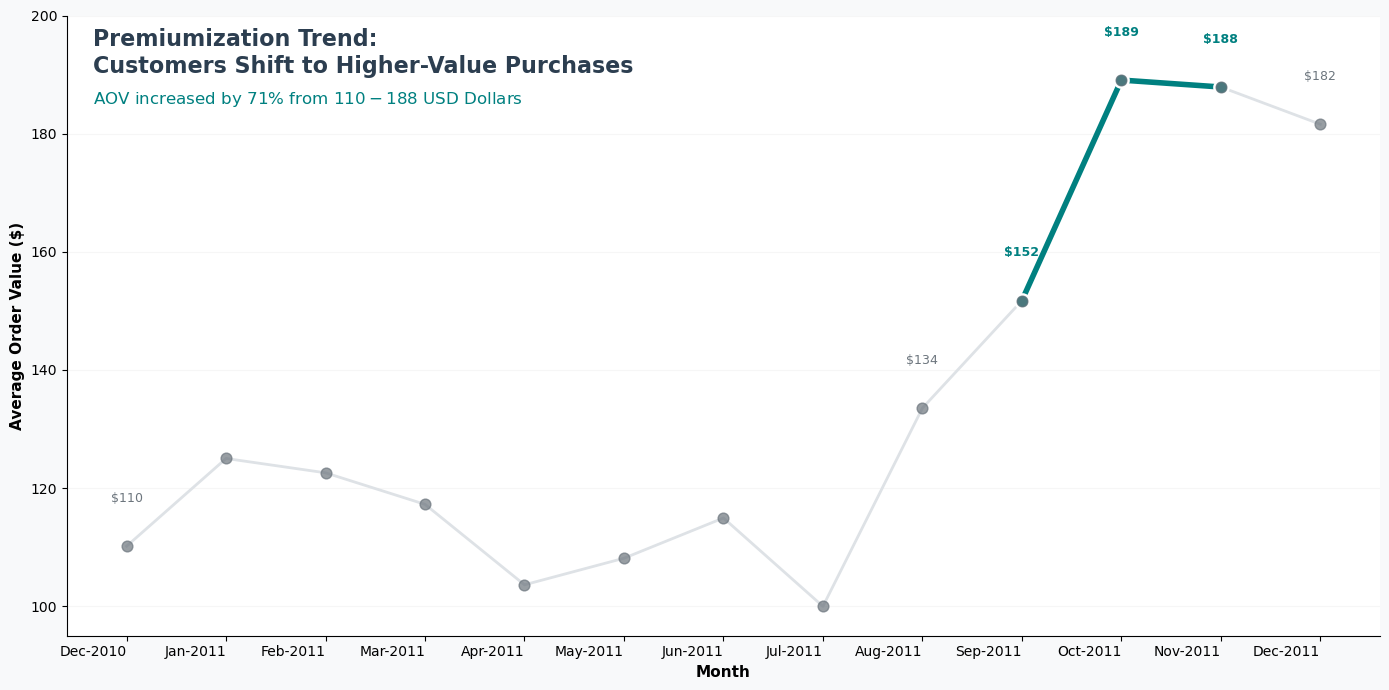

In [137]:
fig, ax = plt.subplots(figsize=(14, 7))

# Set clean background
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#ffffff')

# AOV data
months = monthly_aov['Month_Year'].to_list()
aov_values = monthly_aov['AOV'].to_list()

# Plot main line
ax.plot(months, aov_values, color='#dee2e6', linewidth=2, zorder=1)

# Highlight premiumization phase with thicker line
premium_indices = [9, 10, 11]  # Sep, Oct, Nov
premium_x = [months[i] for i in premium_indices]
premium_y = [aov_values[i] for i in premium_indices]
ax.plot(premium_x, premium_y, color='#008080', linewidth=4, zorder=2, 
        marker='o', markersize=10, markerfacecolor='#008080', 
        markeredgecolor='white', markeredgewidth=2)

# Add all markers
ax.scatter(months, aov_values, color='#6c757d', s=60, zorder=3, alpha=0.7)

# Calculate growth
growth = ((aov_values[11] - aov_values[0]) / aov_values[0]) * 100

# TITLES IN TOP-LEFT CORNER
ax.text(0.02, 0.98, 'Premiumization Trend:\nCustomers Shift to Higher-Value Purchases', 
        transform=ax.transAxes, fontsize=16, fontweight='bold', 
        color='#2c3e50', va='top', ha='left', linespacing=1.2)

ax.text(0.02, 0.88, f'AOV increased by {growth:.0f}% from ${aov_values[0]:.0f} - ${aov_values[11]:.0f} USD Dollars', 
        transform=ax.transAxes, fontsize=12, 
        color='#008080', va='top', ha='left')

# Value labels for key points
key_months = [0, 8, 9, 10, 11, 12]  # Dec-10, Aug, Sep, Oct, Nov, Dec-11
for idx in key_months:
    ax.text(idx, aov_values[idx] + 7, f'${aov_values[idx]:.0f}', 
            ha='center', va='bottom', fontsize=9,
            fontweight='bold' if idx in premium_indices else 'normal',
            color='#008080' if idx in premium_indices else '#6c757d')

# Y-axis
ax.set_ylabel('Average Order Value ($)', fontsize=11, fontweight='bold')
ax.set_ylim(95, 200)

# X-axis
plt.xticks(ha='right')
ax.set_xlabel('Month', fontsize=11, fontweight='bold')

# Clean grid
ax.grid(True, axis='y', alpha=0.1)
ax.set_axisbelow(True)

# Clean borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

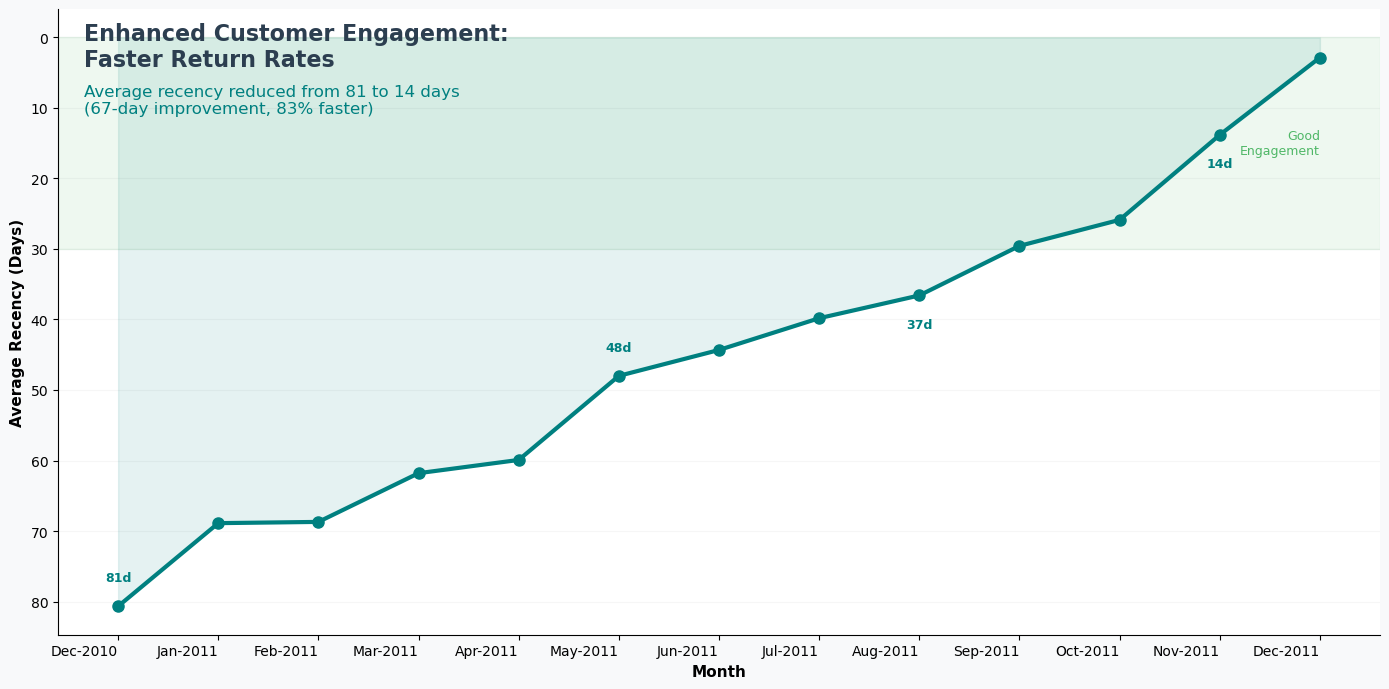

In [138]:
fig, ax = plt.subplots(figsize=(14, 7))

# Set clean background
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#ffffff')

# Get data
recency_months = customer_analysis['Month_Year'].to_list()
recency_values = customer_analysis['Avg_Recency'].to_list()

# Calculate metrics
improvement = recency_values[0] - recency_values[-2]
improvement_rate = (improvement / recency_values[0]) * 100

# Create plot with gradient fill
gradient = ax.fill_between(recency_months, recency_values, color='#008080', alpha=0.1)
line = ax.plot(recency_months, recency_values, color='#008080', linewidth=3, 
               marker='o', markersize=8, markerfacecolor='#008080')

# TITLES IN TOP-LEFT CORNER
ax.text(0.02, 0.98, 'Enhanced Customer Engagement:\nFaster Return Rates', 
        transform=ax.transAxes, fontsize=16, fontweight='bold', 
        color='#2c3e50', va='top', ha='left', linespacing=1.2)

ax.text(0.02, 0.88, f'Average recency reduced from {recency_values[0]:.0f} to {recency_values[-2]:.0f} days\n({improvement:.0f}-day improvement, {improvement_rate:.0f}% faster)', 
        transform=ax.transAxes, fontsize=12, 
        color='#008080', va='top', ha='left')

# Add value labels for key milestones
milestone_months = ['Dec-2010', 'May-2011', 'Aug-2011', 'Nov-2011']
for month in milestone_months:
    if month in recency_months:
        idx = recency_months.index(month)
        value = recency_values[idx]
        
        # Position text above or below based on value
        offset = -5 if value > 40 else 5
        
        ax.text(idx, value + offset, f'{value:.0f}d', 
                ha='center', va='bottom' if offset > 0 else 'top', 
                fontsize=9, fontweight='bold', color='#008080')

# Invert y-axis (lower = better)
ax.invert_yaxis()
ax.set_ylabel('Average Recency (Days)', 
              fontsize=11, fontweight='bold')

# X-axis
plt.xticks(ha='right')
ax.set_xlabel('Month', fontsize=11, fontweight='bold')

# Clean grid
ax.grid(True, axis='y', alpha=0.1)
ax.set_axisbelow(True)

# Clean borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add improvement zone shading
ax.axhspan(0, 30, alpha=0.08, color='#28a745', label='Good Engagement Zone')
ax.text(len(recency_months)-1, 15, 'Good\nEngagement', 
        ha='right', va='center', fontsize=9, color='#28a745', alpha=0.8)

plt.tight_layout()
plt.show()

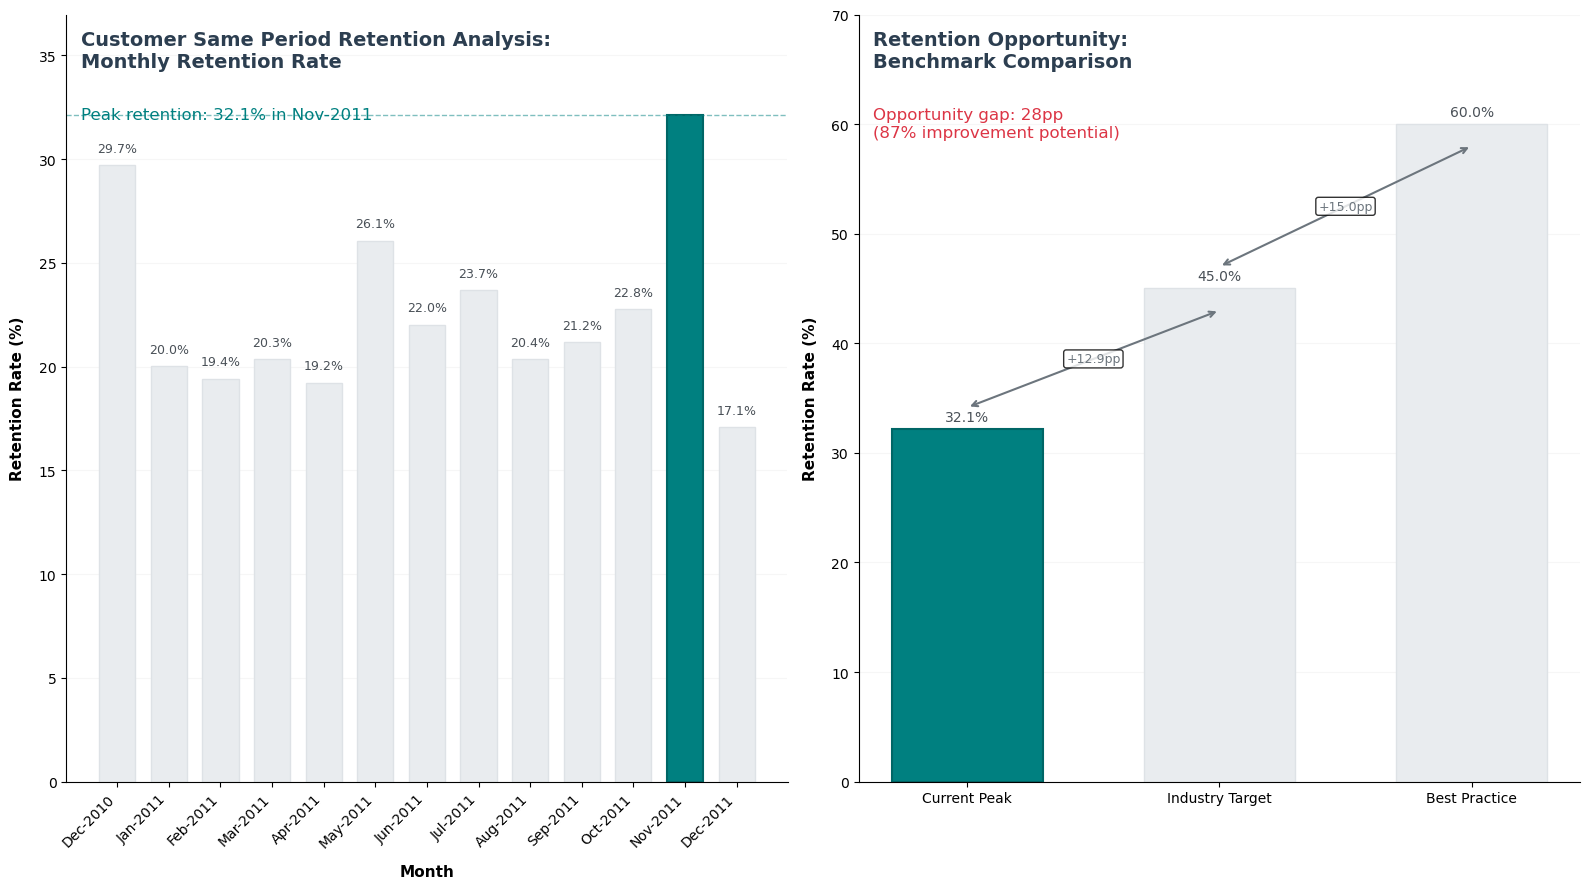

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Get retention data from your customer_analysis DataFrame
retention_months = customer_analysis['Month_Year'].to_list()
retention_rates = customer_analysis['Retention_Rate'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

# Set background colors
fig.patch.set_facecolor('#ffffff')
ax1.set_facecolor('#ffffff')
ax2.set_facecolor('#ffffff')

# --- CHART 1: Retention Rate Trend ---
bars1 = ax1.bar(retention_months, retention_rates, 
                color='#e9ecef', edgecolor='#dee2e6', linewidth=1, width=0.7)

# Highlight peak retention (Nov-11)
peak_index = retention_months.index('Nov-2011') if 'Nov-2011' in retention_months else 11
bars1[peak_index].set_color('#008080')
bars1[peak_index].set_edgecolor('#006666')
bars1[peak_index].set_linewidth(1.5)

# ADD LEFT-ALIGNED TITLES FOR CHART 1
ax1.text(0.02, 0.98, 'Customer Same Period Retention Analysis:\nMonthly Retention Rate', 
        transform=ax1.transAxes, fontsize=14, fontweight='bold', 
        color='#2c3e50', va='top', ha='left', linespacing=1.2)

ax1.text(0.02, 0.88, f'Peak retention: {retention_rates[peak_index]:.1f}% in {retention_months[peak_index]}', 
        transform=ax1.transAxes, fontsize=12, fontweight='normal', 
        color='#008080', va='top', ha='left')

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars1, retention_rates)):
    height = bar.get_height()
    color = 'white' if i == peak_index else '#495057'
    fontweight = 'bold' if i == peak_index else 'normal'
    
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{rate:.1f}%', ha='center', va='bottom', 
            fontsize=9, fontweight=fontweight, color=color)

# Add peak reference line
peak_rate = retention_rates[peak_index]
ax1.axhline(y=peak_rate, color='#008080', linestyle='--', alpha=0.5, linewidth=1)

# Chart 1 formatting
ax1.set_ylabel('Retention Rate (%)', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_xlabel('Month', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_ylim(0, max(retention_rates) * 1.15)
ax1.grid(True, axis='y', alpha=0.1)
ax1.set_axisbelow(True)

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Remove spines
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)

# --- CHART 2: Retention Opportunity Gap ---
# Define benchmarks
current_peak = retention_rates[peak_index]
industry_target = 45.0  # Industry average
best_practice = 60.0    # Top performers

categories = ['Current Peak', 'Industry Target', 'Best Practice']
values = [current_peak, industry_target, best_practice]
colors = ['#008080', '#e9ecef', '#e9ecef']

bars2 = ax2.bar(categories, values, color=colors, 
                edgecolor=['#006666', '#dee2e6', '#dee2e6'], 
                linewidth=[1.5, 1, 1], width=0.6)

# ADD LEFT-ALIGNED TITLES FOR CHART 2
ax2.text(0.02, 0.98, 'Retention Opportunity:\nBenchmark Comparison', 
        transform=ax2.transAxes, fontsize=14, fontweight='bold', 
        color='#2c3e50', va='top', ha='left', linespacing=1.2)

opportunity_gap = best_practice - current_peak
improvement_potential = (opportunity_gap / current_peak) * 100

ax2.text(0.02, 0.88, f'Opportunity gap: {opportunity_gap:.0f}pp\n({improvement_potential:.0f}% improvement potential)', 
        transform=ax2.transAxes, fontsize=12, fontweight='normal', 
        color='#dc3545', va='top', ha='left', linespacing=1.3)

# Add value labels on bars
for bar, value in zip(bars2, values):
    height = bar.get_height()
    color = 'white' if bar.get_facecolor() == '#008080' else '#495057'
    fontweight = 'bold' if bar.get_facecolor() == '#008080' else 'normal'
    
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{value:.1f}%', ha='center', va='bottom', 
            fontsize=10, fontweight=fontweight, color=color)

# Add opportunity arrows
# Current to Industry
ax2.annotate('', xy=(1, industry_target-2), xytext=(0, current_peak+2),
             arrowprops=dict(arrowstyle='<->', color='#6c757d', lw=1.5))
ax2.text(0.5, (current_peak + industry_target)/2, '+12.9pp', 
         ha='center', va='center', fontsize=9, color='#6c757d',
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Industry to Best Practice
ax2.annotate('', xy=(2, best_practice-2), xytext=(1, industry_target+2),
             arrowprops=dict(arrowstyle='<->', color='#6c757d', lw=1.5))
ax2.text(1.5, (industry_target + best_practice)/2, '+15.0pp', 
         ha='center', va='center', fontsize=9, color='#6c757d',
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Chart 2 formatting
ax2.set_ylabel('Retention Rate (%)', fontsize=11, fontweight='bold', labelpad=10)
ax2.set_ylim(0, 70)
ax2.grid(True, axis='y', alpha=0.1)
ax2.set_axisbelow(True)

# Remove spines
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()